# Tester et a évaluer plusieurs regresseurs de prédiction des variables SiteEnergyUse(kBtu) (consommation énergétique) et TotalGHGEmissions (rejet CO2)

Explication du notebook :


- 1er étape : 
             Définition des variables explicatives et à prédire.
             Séparation variable numérique et catégorielle.
             Définition du prétraitement différencié selon les colonnes.
            

- 2ème étape : 
             Split en jeu d'entrainement et de test. 
             Début du Pipeline des données. 
             - imputation
             - target encoding
             - standardisation
             - Définition des régresseurs

- 3ème étape : 
             Evaluation d'une baseline.
             Courbe prédiction/réelle Y.
             Utilisation le coefficient de détermination R² et du RMSE. 
             R2 mesure la proportion de la variance de la variable dépendante expliquée par les variables indépendantes.
             L'écart quadratique moyen (RMSE) est l'écart-type des résidus (erreurs de prévision).
             Recherche du meilleur regresseur
             Affichage barplot
             
- 4ème étape : 
             Choix de Extra Tree comme regresseur
             utiliser les logs
             Pour obtenir les résultats les plus fiables possibles, nous allons utiliser une validation croisée
             Choix des hyperparametres avec un Kfold/RandomizedSearchCV
             Effets de la taille du jeu de données d'entraînement (learning curve)
             Effet des hyperparametre sur le R2 et RMSE

- Pas de bénéfice a utiliser un jeu de variable restreint (% importance des features)
- ENERGYSTARScore n'est pas une variable pertinente dans notre modèle de regresseur. (faible % importance des features)
- La taille du jeu de données d'entraînement détermine la qualité de prédiction de notre modèle. La ville de Seattle pourrait-elle déjà utiliser le modèle ? ou devrait-elle continuer à collecter plus des données ?

- Courbes d'apprentissage :
    Evaluation de l'influence des hyperparamètres
    Comparons les modèles sur le critère de la RMSE divisée par la moyenne de la valeur à prédire

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

In [3]:
data = pd.read_csv('clean_dataset.csv').reset_index()

In [4]:
data.dtypes

index                                int64
Unnamed: 0                           int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
CouncilDistrictCode                  int64
Neighborhood                        object
YearBuilt                            int64
NumberofFloors                     float64
PropertyGFABuilding(s)               int64
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLargestPropertyUseType        object
SecondLargestPropertyUseTypeGFA    float64
ENERGYSTARScore                    float64
SiteEnergyUse(kBtu)                float64
TotalGHGEmissions                  float64
Latitude                           float64
Longitude                          float64
Address                             object
Log2_SiteEnergyUse(kBtu)           float64
Log2_TotalGHGEmissions             float64
Log2_LargestPropertyUseTypeGFA     float64
dtype: obje

In [5]:
data = data.drop(['Unnamed: 0'], axis=1)

In [6]:
data = data.drop(['DataYear'], axis=1)

In [7]:
data = data.drop(['ENERGYSTARScore'], axis=1)

In [8]:
data.shape

(6131, 20)

In [9]:
data.isna().sum().sum()

0

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6131 entries, 0 to 6130
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   index                            6131 non-null   int64  
 1   BuildingType                     6131 non-null   object 
 2   PrimaryPropertyType              6131 non-null   object 
 3   CouncilDistrictCode              6131 non-null   int64  
 4   Neighborhood                     6131 non-null   object 
 5   YearBuilt                        6131 non-null   int64  
 6   NumberofFloors                   6131 non-null   float64
 7   PropertyGFABuilding(s)           6131 non-null   int64  
 8   LargestPropertyUseType           6131 non-null   object 
 9   LargestPropertyUseTypeGFA        6131 non-null   float64
 10  SecondLargestPropertyUseType     6131 non-null   object 
 11  SecondLargestPropertyUseTypeGFA  6131 non-null   float64
 12  SiteEnergyUse(kBtu) 

## 0. Définition des variables explicatives


In [11]:
var_explic = [#'DataYear',
 'BuildingType',
 'PrimaryPropertyType',
 'CouncilDistrictCode',
 'Neighborhood',
 'YearBuilt',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'Log2_LargestPropertyUseTypeGFA',
 #'ENERGYSTARScore',
             ]

## Définition des variables numériques et catégorielles

In [12]:
# Définition des variables numériques et catégorielles
categorical_cols = data[var_explic].select_dtypes(['object']).columns
numerical_cols = data[var_explic].select_dtypes(['int64','float64']).columns

## 1. Début du pipeline sickit-learn

### Séparation jeu de données apprentissage et validation avec sickit-learn

In [13]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, train_size=0.8, random_state=0)

### Préparation des données (normalisation/scaling des variables numérique & TargetEncoder des variables catégorielle)

In [14]:
# Preprocessor :
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler()),  
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('encoder', TargetEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('std_scaler', StandardScaler()),  
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
    ])

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [15]:
# Bundle preprocessing and modeling code in a pipeline

def define_pipeline(preprocessor, regressor):

    modeling_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                        ('regressor', regressor)
                                        ])

    return modeling_pipeline

### Regresseurs

In [16]:
# regresseurs

from sklearn.dummy import DummyRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

regressors = {
    'Dummy': DummyRegressor(),
    'Linear': LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(),
    'Elastic Net': ElasticNet(),
    'SVR': SVR(kernel="rbf", C=300, gamma=1),
    'Random Forest': RandomForestRegressor(n_estimators=100, n_jobs=-1),
    'Extra Tree': ExtraTreesRegressor(n_estimators=100, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state = 42),
}

## 2. Evaluation du pipeline & baseline

In [17]:
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [18]:
rmse_with = []
r2_with = []
rmse_without = []
r2_without = []

def plot(reg, features):

    with plt.style.context('bmh'):
        f, (ax0) = plt.subplots(1, sharey=True)

        
        regr = define_pipeline(preprocessor, reg)
        regr.fit(train_set[features], train_set['SiteEnergyUse(kBtu)'])
        var_predic = regr.predict(test_set[features])
        
        rmse_without.append(mean_squared_error(test_set['SiteEnergyUse(kBtu)'], var_predic, squared=False))
        r2_without.append(r2_score(test_set['SiteEnergyUse(kBtu)'], var_predic))

        ax0.scatter(test_set['SiteEnergyUse(kBtu)'], var_predic)
        ax0.plot([0, 10**8], [0, 10**8], '--k')
        ax0.set_ylabel('Target predicted ÿ')
        ax0.set_xlabel('True Target y')
        ax0.set_title(
            reg)
        ax0.text(0.5*10**7, 0.7*10**8, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (
            r2_score(test_set['SiteEnergyUse(kBtu)'], var_predic), 
            median_absolute_error(test_set['SiteEnergyUse(kBtu)'], var_predic), 
            mean_squared_error(test_set['SiteEnergyUse(kBtu)'], var_predic, squared=False)))
        ax0.set_xlim([0, 0.7*10**8])
        ax0.set_ylim([0, 0.8*10**8])
        f.suptitle("SiteEnergyUse(kBtu) predictions", x=0.6, y=0.05)
        f.tight_layout(rect=[0.05, 0.05, 1.2, 1.2])

        plt.show()

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


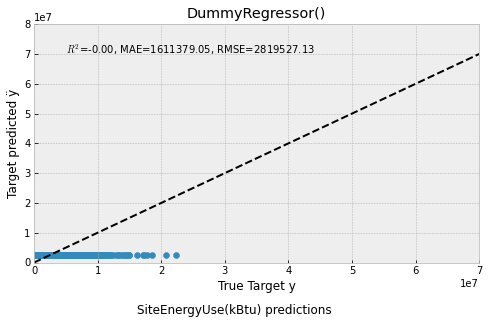

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


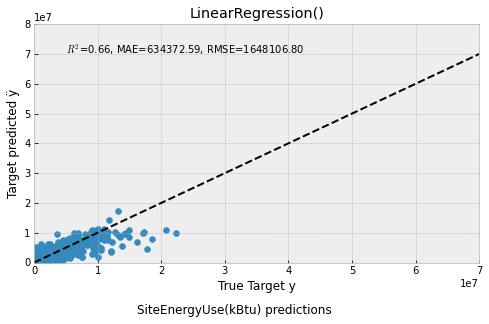

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


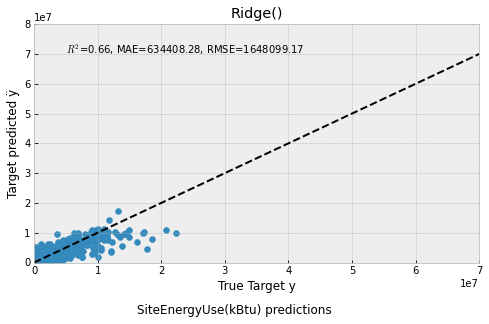

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


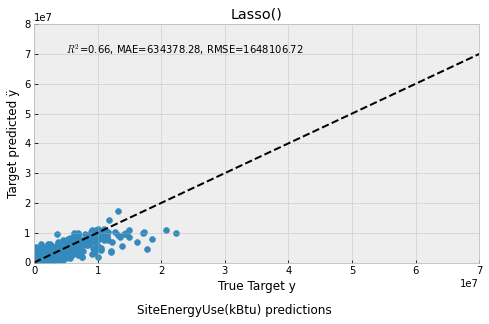

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


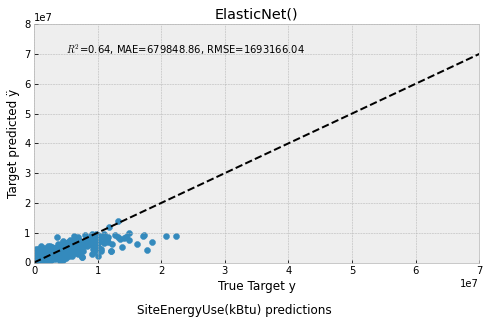

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


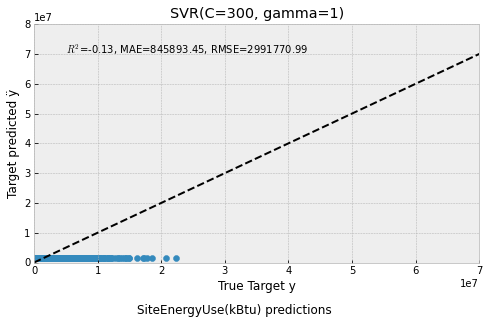

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


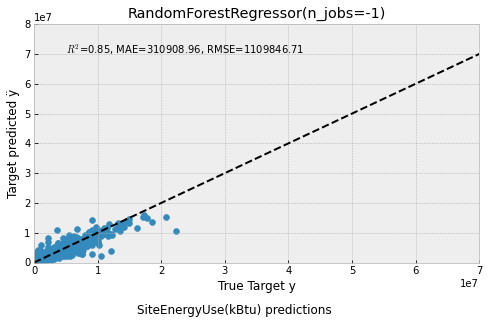

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


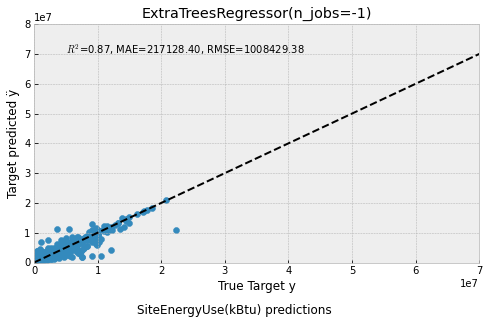

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


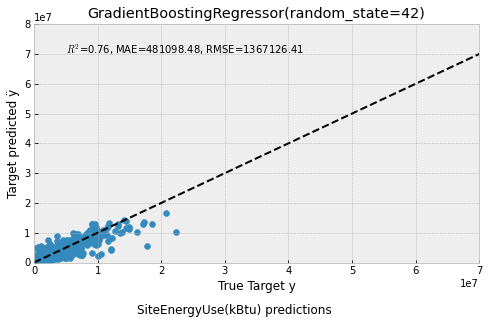

In [19]:
for name_reg, reg in regressors.items() :
    plot(reg, var_explic)

## 3. Recherche du meilleur regresseur pour 'SiteEnergyUse(kBtu)'

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve

In [21]:
# Résultats
y_pred = {}
rmse = {}
r2 = {}
final_model = {}

# Scoring, moyenne et écart-type
def display_scores(scores, scoring=["neg_mean_squared_error", "r2"]) :
    
    print("Resultats de la cross validation :")
     
    for metric in scoring : 
    
        print("Métrique utilisé : {} \n".format(metric))
        results = -scores["test_" + metric]
        if metric == "neg_mean_squared_error" :
            results = np.sqrt(results) #RMSE
        elif metric == "r2" :
            results = scores["test_" + metric]
            
        print("\t - Moyenne :", results.mean())
        print("\t - Ecart-type :", results.std())
        print("\t - Coefficient de variation : {:.2f} %".format(results.std()/results.mean()*100))
        print("\n")

In [22]:
# Cross validation avec RMSE et R2
def cross_val(estimator, X, y):

    kf = KFold(n_splits=10)

   
    scores = cross_validate(estimator,
                            X,
                            y,
                            scoring=["neg_mean_squared_error",
                                     "neg_mean_absolute_error",
                                     "r2"],
                            cv=kf)

    return scores

In [23]:
# Les regresseurs sont testés 1 a 1 par cross-validation
for name_reg, reg in regressors.items():
    
    print("_____", name_reg, "_____")

    pipeline = define_pipeline(preprocessor, reg)

    # cross-validation
    scores = cross_val(pipeline,
                       train_set[var_explic],
                       train_set['Log2_SiteEnergyUse(kBtu)'])

    # calcul de la RMSE
    rmse[name_reg] = np.sqrt(-scores["test_neg_mean_squared_error"])

    # calcul de R2
    r2[name_reg] = scores["test_r2"]

    # Affichage des résultats
    display_scores(scores,
                   scoring=["neg_mean_squared_error",
                            "r2"])

_____ Dummy _____


C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 0.9271447518217348
	 - Ecart-type : 0.03641840548831777
	 - Coefficient de variation : 3.93 %


Métrique utilisé : r2 

	 - Moyenne : -0.001742440773875731
	 - Ecart-type : 0.002780628017725639
	 - Coefficient de variation : -159.58 %


_____ Linear _____


C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 0.5816486782050959
	 - Ecart-type : 0.028924497222387775
	 - Coefficient de variation : 4.97 %


Métrique utilisé : r2 

	 - Moyenne : 0.6052983795095023
	 - Ecart-type : 0.025357703239696727
	 - Coefficient de variation : 4.19 %


_____ Ridge _____


C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 0.5816453746304037
	 - Ecart-type : 0.028930827139598474
	 - Coefficient de variation : 4.97 %


Métrique utilisé : r2 

	 - Moyenne : 0.6053036345668689
	 - Ecart-type : 0.025353188678698853
	 - Coefficient de variation : 4.19 %


_____ Lasso _____


C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 0.9271447518217348
	 - Ecart-type : 0.03641840548831777
	 - Coefficient de variation : 3.93 %


Métrique utilisé : r2 

	 - Moyenne : -0.001742440773875731
	 - Ecart-type : 0.002780628017725639
	 - Coefficient de variation : -159.58 %


_____ Elastic Net _____


C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 0.8698224840981277
	 - Ecart-type : 0.035536474390762664
	 - Coefficient de variation : 4.09 %


Métrique utilisé : r2 

	 - Moyenne : 0.11840250723444017
	 - Ecart-type : 0.0049906173242988145
	 - Coefficient de variation : 4.21 %


_____ SVR _____


C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 0.6336542786314544
	 - Ecart-type : 0.045445660946879594
	 - Coefficient de variation : 7.17 %


Métrique utilisé : r2 

	 - Moyenne : 0.5266893515787913
	 - Ecart-type : 0.0860555431709041
	 - Coefficient de variation : 16.34 %


_____ Random Forest _____


C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 0.4218002501249396
	 - Ecart-type : 0.03803373401507083
	 - Coefficient de variation : 9.02 %


Métrique utilisé : r2 

	 - Moyenne : 0.7918311063416094
	 - Ecart-type : 0.03033381765736685
	 - Coefficient de variation : 3.83 %


_____ Extra Tree _____


C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 0.3859236587733569
	 - Ecart-type : 0.03569360990334311
	 - Coefficient de variation : 9.25 %


Métrique utilisé : r2 

	 - Moyenne : 0.8258587852114513
	 - Ecart-type : 0.025061551308364897
	 - Coefficient de variation : 3.03 %


_____ Gradient Boosting _____


C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 0.5146326233597119
	 - Ecart-type : 0.031594235239725356
	 - Coefficient de variation : 6.14 %


Métrique utilisé : r2 

	 - Moyenne : 0.6905107756684533
	 - Ecart-type : 0.030866047285910442
	 - Coefficient de variation : 4.47 %




In [24]:
# Barplot des résultats
def graphical_display(results, title) :
    
    x = list(results)
    y = np.array(list(results.values()))
    mean = [score.mean() for score in np.array(list(results.values()))]

    fig = plt.figure(1, figsize=(10,30))
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1
    
    plt.subplot(311)
    sns.barplot(x=x, y=mean)
    plt.ylabel("Moyenne")
    plt.title(title)
    for index, value in enumerate(mean):
        plt.text(index-0.3, value+0.2, str("{:.2e}".format(value)))
    
    plt.show()

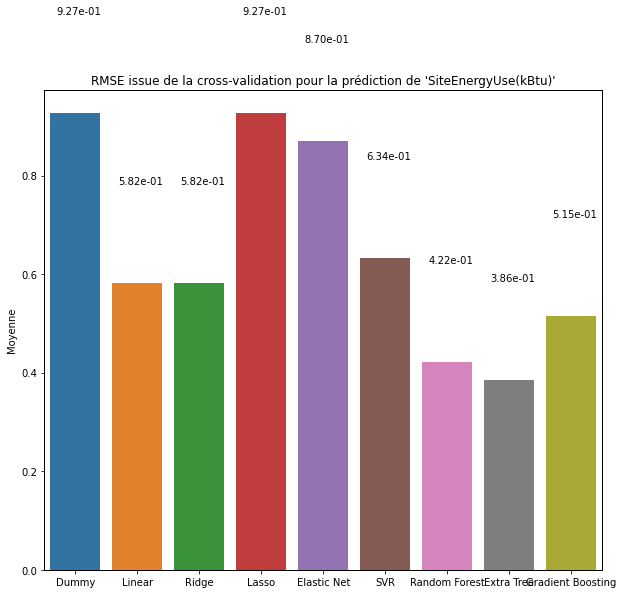

In [25]:
# Affichage de la RMSE pour chaque modèle
graphical_display(rmse, "RMSE issue de la cross-validation pour la prédiction de 'SiteEnergyUse(kBtu)'")

In [26]:
regressors_to_plot = ['Random Forest',
                  'Extra Tree',
                  'Gradient Boosting']

In [27]:
# Boxplot des résultats
def boxplot(results, title, ylabel) :
    
    with plt.style.context('bmh'):        
        fig = plt.figure(1, figsize=(12,6))
        plt.rcParams["axes.edgecolor"] = "black"
        plt.rcParams["axes.linewidth"] = 1

        plt.boxplot([results[model] for model in regressors_to_plot], labels=regressors_to_plot)
        plt.ylabel(ylabel)
        plt.title(title)

        plt.show()

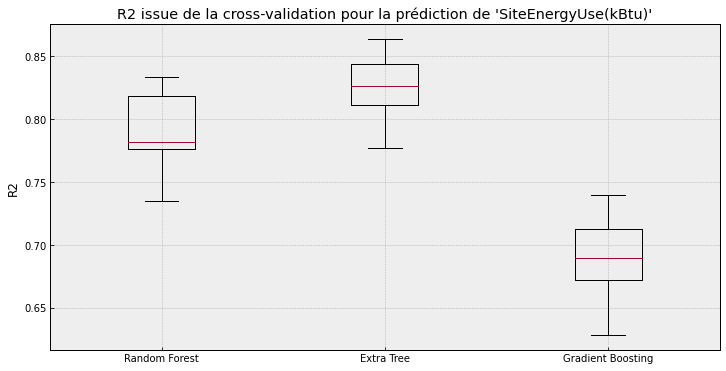

In [28]:
boxplot(r2, "R2 issue de la cross-validation pour la prédiction de 'SiteEnergyUse(kBtu)'", "R2")

In [29]:
print('Les scores pour R2 et RMSE sont {} et  {} soit {:.2%} d\'erreur par rapport à la valeur maximale de l\'énergie pour le régresseur Extra Tree.'.format(r2['Extra Tree'].mean(), rmse['Extra Tree'].mean(), rmse['Extra Tree'].mean()/data['Log2_SiteEnergyUse(kBtu)'].max()))

Les scores pour R2 et RMSE sont 0.8258587852114513 et  0.3859236587733569 soit 2.27% d'erreur par rapport à la valeur maximale de l'énergie pour le régresseur Extra Tree.


## 4. Optimisation des hyperparametres pour 'SiteEnergyUse(kBtu)'

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_grid_forest = [{
    "regressor__max_features": sp_randint(2, 5), # number of features to consider at each node
    "regressor__max_depth": sp_randint(2, 5), # maximum depth (to prune) a stump 
    "regressor__min_samples_leaf": sp_randint(1, 100), # minimum number of samples required to be at a leaf node
}]

parameters = {
    'n_estimators' : [10,50,100,300,500], #nombre d'arbres de décision
    'min_samples_leaf' : [1,3,5,10], #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre
}

param_grid = {'n_estimators': [600],
              'max_features': ['auto'],
              'n_jobs': [-1],
              'random_state': [42],
              'max_depth': [None],
              'min_samples_leaf': [1],
              'min_samples_split': [2],
              }

In [31]:
# Hyperparamètres pour les modèles ensemblistes d'arbres de regression
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'preprocessor__cat__imputer__strategy': ['mean', 'median'],
    'regressor__n_estimators' : [10,50,100,300,500,1000],
    'regressor__max_depth' : [None],
    'regressor__max_features' : ['auto', 'sqrt'],
    'regressor__min_samples_split': sp_randint(1, 11),
    'regressor__min_samples_leaf': sp_randint(1, 11)
}

In [32]:
# Fonction d'optimisation du régresseur
def optimisation(regressor, preprocessor, x, y, target_name):
    # Définition du modèle avec les hyperparamètres par défaut
    model = define_pipeline(preprocessor, regressor)

    # Définition de la procédure cross-validation
    cv = KFold(n_splits=10, shuffle=True)

    # Définition de la procédure RandomizedSearchCV 
    grid_search = RandomizedSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, n_iter=100,
                                     random_state=42)

    # Execution du grid search
    grid_result = grid_search.fit(x, y)

    score = grid_result.best_estimator_.score(x, y)  # calcul du R2 sur tout le jeu d'entrainement
    
    final_model[target_name] = grid_result.best_estimator_
    print("Hyperparamètres du meilleur modèle :", grid_result.best_params_)
    print('\n')
    print('____', 'SCORES :''____')
    print("R2 score sur tout le jeux d'entrainement: ", score)
    print("Moyenne cross-validée de la RMSE du meilleur modèle sur le jeu d'entrainement:",
          np.sqrt(-grid_result.best_score_))

In [33]:
optimisation(ExtraTreesRegressor(), 
          preprocessor, 
          train_set[var_explic], 
          train_set['Log2_SiteEnergyUse(kBtu)'], 
          'Log2_SiteEnergyUse(kBtu)'
         )

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the fai

Hyperparamètres du meilleur modèle : {'preprocessor__cat__imputer__strategy': 'mean', 'preprocessor__num__imputer__strategy': 'most_frequent', 'regressor__max_depth': None, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 4, 'regressor__n_estimators': 500}


____ SCORES :____
R2 score sur tout le jeux d'entrainement:  0.9932616107230975
Moyenne cross-validée de la RMSE du meilleur modèle sur le jeu d'entrainement: 0.3953161236383708


In [34]:
# Fonction courbes d'apprentissage

train_sizes = [1000, 3000, 5900]

def learning_curves(estimator, data, features, target, train_sizes, cv, ylim):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, data[features], data[target], train_sizes =
    train_sizes,
    cv = cv, 
    scoring = 'neg_mean_squared_error')
    
    train_scores_mean = np.sqrt(-train_scores.mean(axis = 1))
    validation_scores_mean = np.sqrt(-validation_scores.mean(axis = 1))

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('RMSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ExtraTreesRegressor()' 
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,ylim)

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

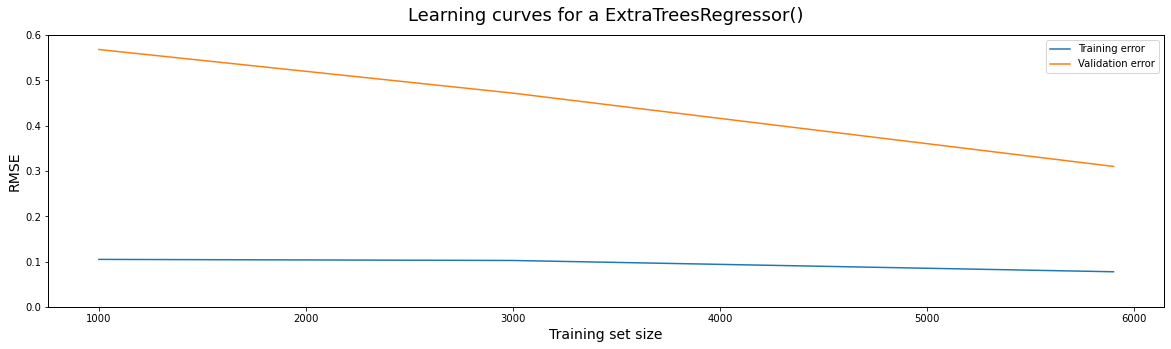

In [35]:
# Courbes d'apprentissage du regresseur optimisé pour la prédiction de SiteEnergyUse avec tous les variables eplicatives

plt.figure(figsize = (20,5))

learning_curves(final_model['Log2_SiteEnergyUse(kBtu)'], data, var_explic, 'Log2_SiteEnergyUse(kBtu)', train_sizes=train_sizes, cv = 30, 
                ylim = 0.6)

In [36]:
# Barplot de l'importance de la contribution de chaque variable au régresseur
def plot_feature_importances(target, features):
    
    feature_importances = final_model[target][-1].feature_importances_

    # Les features sont triés par importance pour l'affichage graphique
    features_labels = [attrib for value, attrib in sorted(zip(feature_importances, features), reverse=True)]
    features_values = [value for value, attrib in sorted(zip(feature_importances, features), reverse=True)]

    # Affichage Bar Plot
    fig = plt.figure(1, figsize=(15,5))
    sns.barplot(x=features_labels[0:30], y=[100*v for v in features_values[0:30]], orient='v')
    plt.ylabel("%")
    plt.title("Features Importances")
    plt.xticks(rotation=90)
    plt.show()

In [37]:
# Pourcentage de l'importance des variables pour la prédiction de SiteEnergyUse(kBtu)
feature_importances_energy = final_model['Log2_SiteEnergyUse(kBtu)'][-1].feature_importances_
feature_importances_energy

array([0.0254891 , 0.05126928, 0.02803691, 0.12314923, 0.19782857,
       0.0252403 , 0.21526739, 0.02993959, 0.16545383, 0.02821985,
       0.08318783, 0.02691812])

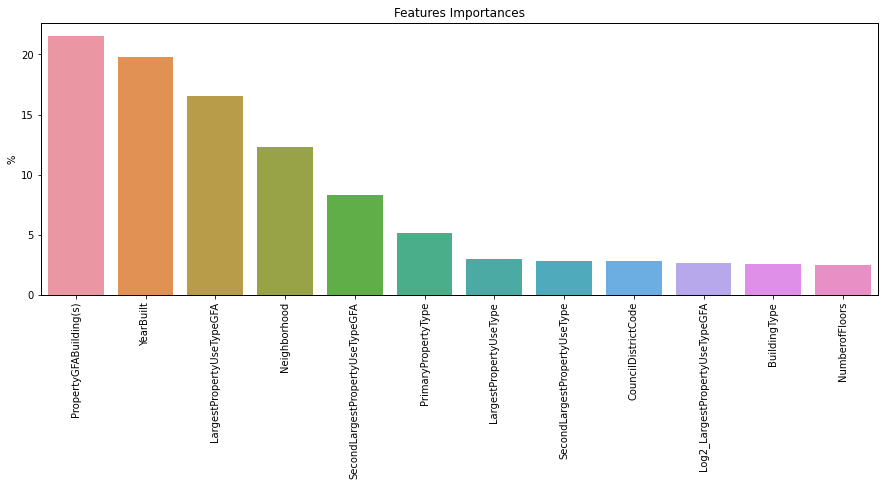

In [38]:
plot_feature_importances('Log2_SiteEnergyUse(kBtu)', var_explic)

In [39]:
# Fonction prédiction à partir du jeu test
def plot_bis(target, features):
    with plt.style.context('bmh'):

        plt.scatter(test_set[target],
                    final_model[target].predict(test_set[features]))
        plt.plot([0, max(test_set[target])], [0, max(test_set[target])], '--k')
        plt.ylabel('Target predicted ÿ')
        plt.xlabel('True Target y')
        plt.title(target)
        plt.text(0.05*max(test_set[target]), 0.5*max(test_set[target]), r'$R^2$=%.2f, RMSE=%.2f' % (
            r2_score(test_set[target],
                     final_model[target].predict(test_set[features])),
            mean_squared_error(test_set[target],
                               final_model[target].predict(test_set[features]), squared=False)))
        plt.xlim([0, max(final_model[target].predict(test_set[features]))])
        plt.ylim([0, max(final_model[target].predict(test_set[features]))])

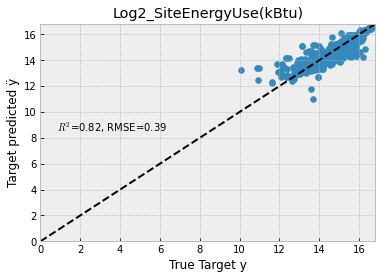

In [40]:
# Les tests avec seulement les variables importantes n'ont rien donné de plus en précision 
# Prédiction SiteEnergyUse sur dataset test
plot_bis('Log2_SiteEnergyUse(kBtu)', var_explic)

### Recherche du meilleur modèle pour 'TotalGHGEmissions'

In [41]:
# Résultats
y_pred = {}
rmse = {}
r2 = {}

# Les regressors sont testés 1 à 1 par cross-validation
for name_reg, reg in regressors.items():
    print("_____", name_reg, "_____")

    pipeline = define_pipeline(preprocessor, reg)

    # cross-validation
    scores = cross_val(pipeline,
                       train_set[var_explic],
                       train_set['Log2_TotalGHGEmissions'])

    # calcul de la RMSE
    rmse[name_reg] = np.sqrt(-scores["test_neg_mean_squared_error"])

    # calcul de R2
    r2[name_reg] = scores["test_r2"]

    # Affichage des résultats
    display_scores(scores,
                   scoring=["neg_mean_squared_error",
                            "neg_mean_absolute_error",
                            "r2"])

_____ Dummy _____


C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 1.221713486470775
	 - Ecart-type : 0.03007483021186421
	 - Coefficient de variation : 2.46 %


Métrique utilisé : neg_mean_absolute_error 

	 - Moyenne : 1.0392404417265388
	 - Ecart-type : 0.030359433887534534
	 - Coefficient de variation : 2.92 %


Métrique utilisé : r2 

	 - Moyenne : -0.001294387996543489
	 - Ecart-type : 0.001298679751534928
	 - Coefficient de variation : -100.33 %


_____ Linear _____


C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 0.9293157860076627
	 - Ecart-type : 0.023605819986817263
	 - Coefficient de variation : 2.54 %


Métrique utilisé : neg_mean_absolute_error 

	 - Moyenne : 0.7668414863107604
	 - Ecart-type : 0.018928069290836423
	 - Coefficient de variation : 2.47 %


Métrique utilisé : r2 

	 - Moyenne : 0.4198013990052848
	 - Ecart-type : 0.03106959469666852
	 - Coefficient de variation : 7.40 %


_____ Ridge _____


C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 0.9293130653265174
	 - Ecart-type : 0.023610544212786164
	 - Coefficient de variation : 2.54 %


Métrique utilisé : neg_mean_absolute_error 

	 - Moyenne : 0.7668473296121934
	 - Ecart-type : 0.018934761703293487
	 - Coefficient de variation : 2.47 %


Métrique utilisé : r2 

	 - Moyenne : 0.41980530738293426
	 - Ecart-type : 0.03106273710158802
	 - Coefficient de variation : 7.40 %


_____ Lasso _____


C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 1.221713486470775
	 - Ecart-type : 0.03007483021186421
	 - Coefficient de variation : 2.46 %


Métrique utilisé : neg_mean_absolute_error 

	 - Moyenne : 1.0392404417265388
	 - Ecart-type : 0.030359433887534534
	 - Coefficient de variation : 2.92 %


Métrique utilisé : r2 

	 - Moyenne : -0.001294387996543489
	 - Ecart-type : 0.001298679751534928
	 - Coefficient de variation : -100.33 %


_____ Elastic Net _____


C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 1.1630615206326569
	 - Ecart-type : 0.03116462011834379
	 - Coefficient de variation : 2.68 %


Métrique utilisé : neg_mean_absolute_error 

	 - Moyenne : 0.9905305468701704
	 - Ecart-type : 0.03146879829900851
	 - Coefficient de variation : 3.18 %


Métrique utilisé : r2 

	 - Moyenne : 0.09262662043602612
	 - Ecart-type : 0.005299200606764505
	 - Coefficient de variation : 5.72 %


_____ SVR _____


C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 0.9415790224230319
	 - Ecart-type : 0.03987891274749908
	 - Coefficient de variation : 4.24 %


Métrique utilisé : neg_mean_absolute_error 

	 - Moyenne : 0.5929843443402691
	 - Ecart-type : 0.02053615404239573
	 - Coefficient de variation : 3.46 %


Métrique utilisé : r2 

	 - Moyenne : 0.4034744970694679
	 - Ecart-type : 0.05424362462091501
	 - Coefficient de variation : 13.44 %


_____ Random Forest _____


C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 0.653566973923768
	 - Ecart-type : 0.029466772582462792
	 - Coefficient de variation : 4.51 %


Métrique utilisé : neg_mean_absolute_error 

	 - Moyenne : 0.46433870883262457
	 - Ecart-type : 0.01760640677273833
	 - Coefficient de variation : 3.79 %


Métrique utilisé : r2 

	 - Moyenne : 0.7128789189292775
	 - Ecart-type : 0.023692775166124006
	 - Coefficient de variation : 3.32 %


_____ Extra Tree _____


C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 0.5998005340439675
	 - Ecart-type : 0.03006496682677831
	 - Coefficient de variation : 5.01 %


Métrique utilisé : neg_mean_absolute_error 

	 - Moyenne : 0.3691935501325168
	 - Ecart-type : 0.014715592381569845
	 - Coefficient de variation : 3.99 %


Métrique utilisé : r2 

	 - Moyenne : 0.7581596195988765
	 - Ecart-type : 0.02159802190286109
	 - Coefficient de variation : 2.85 %


_____ Gradient Boosting _____


C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 0.8241885908171411
	 - Ecart-type : 0.028410010378799876
	 - Coefficient de variation : 3.45 %


Métrique utilisé : neg_mean_absolute_error 

	 - Moyenne : 0.6477523321500864
	 - Ecart-type : 0.01982699734575541
	 - Coefficient de variation : 3.06 %


Métrique utilisé : r2 

	 - Moyenne : 0.543329920710661
	 - Ecart-type : 0.033110324552545325
	 - Coefficient de variation : 6.09 %




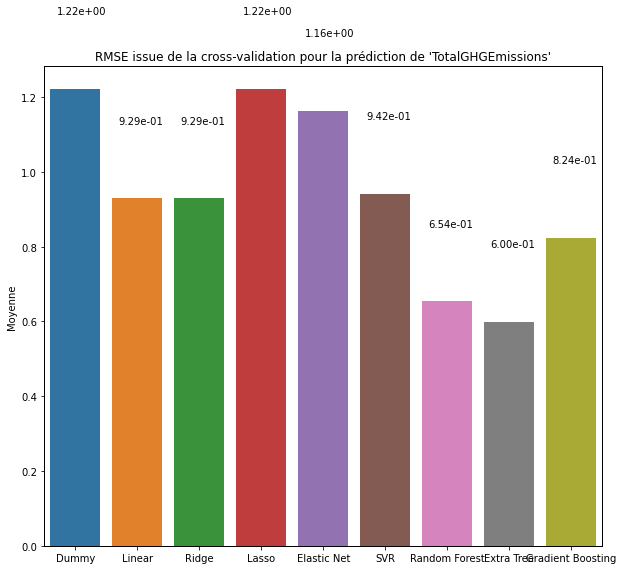

In [42]:
# Affichage des résultats de la RMSE
graphical_display(rmse, "RMSE issue de la cross-validation pour la prédiction de 'TotalGHGEmissions'")

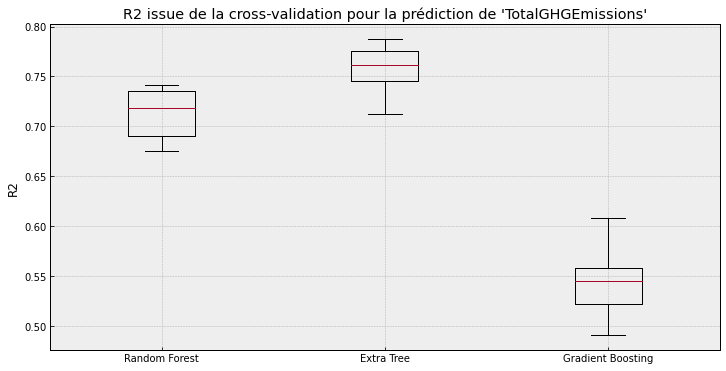

In [43]:
# Boxplot des résultats
boxplot(r2, "R2 issue de la cross-validation pour la prédiction de 'TotalGHGEmissions'", "R2")

In [44]:
print('Les scores pour R2 et RMSE sont respectivement de {} et de {} soit {:.2%} d\'erreur par rapport à la valeur maximale des émissions de CO2 pour le modèle avec Extra Tree Regressor.'.format(r2['Extra Tree'].mean(), rmse['Extra Tree'].mean(), rmse['Extra Tree'].mean()/data['Log2_TotalGHGEmissions'].max()))

Les scores pour R2 et RMSE sont respectivement de 0.7581596195988765 et de 0.5998005340439675 soit 10.24% d'erreur par rapport à la valeur maximale des émissions de CO2 pour le modèle avec Extra Tree Regressor.


In [45]:
optimisation(ExtraTreesRegressor(),
          preprocessor,
          train_set[var_explic],
          train_set['Log2_TotalGHGEmissions'],
          'Log2_TotalGHGEmissions')

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the fai

Hyperparamètres du meilleur modèle : {'preprocessor__cat__imputer__strategy': 'mean', 'preprocessor__num__imputer__strategy': 'most_frequent', 'regressor__max_depth': None, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 4, 'regressor__n_estimators': 500}


____ SCORES :____
R2 score sur tout le jeux d'entrainement:  0.9914721048849621
Moyenne cross-validée de la RMSE du meilleur modèle sur le jeu d'entrainement: 0.5992192308653655


C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

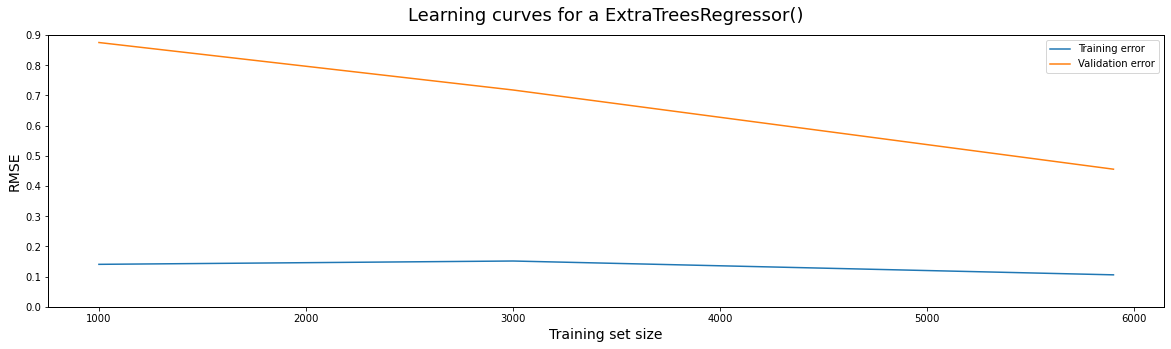

In [46]:
plt.figure(figsize = (20,5))

learning_curves(final_model["Log2_TotalGHGEmissions"], data, var_explic, 'Log2_TotalGHGEmissions', train_sizes=train_sizes, cv = 30, 
                ylim = 0.9)

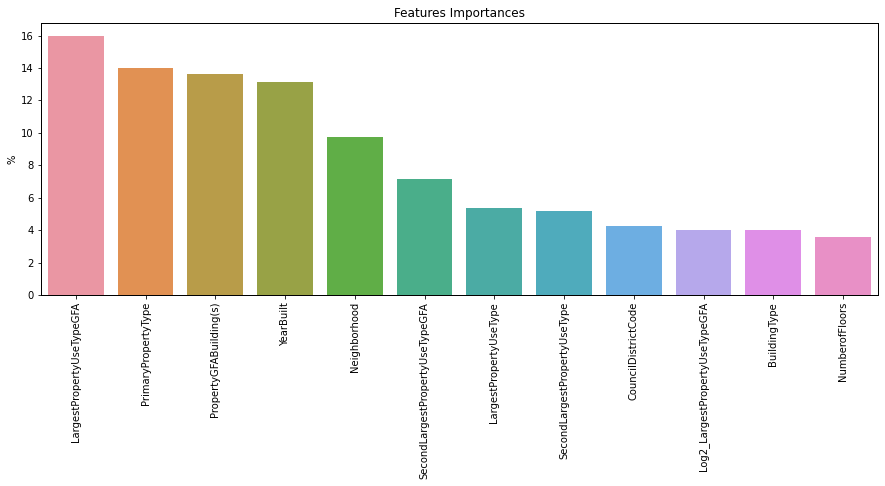

In [47]:
plot_feature_importances('Log2_TotalGHGEmissions', var_explic)

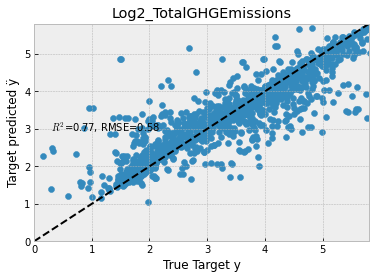

In [48]:
# Les tests avec seulement les variables importantes n'ont rien donné de plus en précision 
# Prédiction 'TotalGHGEmissions' sur dataset test
plot_bis('Log2_TotalGHGEmissions', var_explic)

# Evaluation de l'influence des hyperparamètres sur le RMSE

In [49]:
# Sur qu'une seule variable ( même résultats)

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

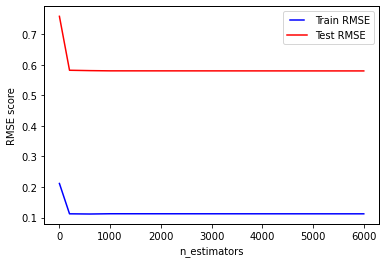

In [50]:
# Relation nombres d'arbres et RMSE
from matplotlib.legend_handler import HandlerLine2D
n_estimators = (1,200,600,1000,6000)

train_results = []
test_results = []

for v in n_estimators:
    model = final_model['Log2_TotalGHGEmissions'].set_params(
        regressor__n_estimators=v)
    model.fit(train_set[var_explic], train_set['Log2_TotalGHGEmissions'])

    y_train_pred = model.predict(train_set[var_explic])
    rmse = mean_squared_error(
        train_set['Log2_TotalGHGEmissions'], y_train_pred, squared=False)
    train_results.append(rmse)

    y_test_pred = model.predict(test_set[var_explic])
    rmse = mean_squared_error(
        test_set['Log2_TotalGHGEmissions'], y_test_pred, squared=False)
    test_results.append(rmse)

line1, = plt.plot(n_estimators, train_results, 'b', label='Train RMSE')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMSE score')
plt.xlabel('n_estimators')
plt.show()

C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\tropical noise\anaconda3\lib\site-pa

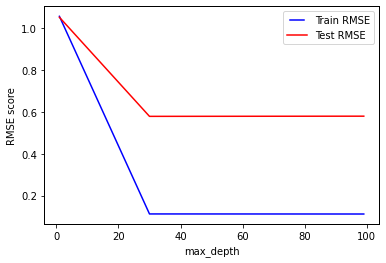

In [51]:
# Relation nombres d'arbres et RMSE
from matplotlib.legend_handler import HandlerLine2D
max_depth = (1,30,99)

train_results = []
test_results = []

for v in max_depth :
    model = final_model['Log2_TotalGHGEmissions'].set_params(
        regressor__max_depth=v)
    model.fit(train_set[var_explic], train_set['Log2_TotalGHGEmissions'])

    y_train_pred = model.predict(train_set[var_explic])
    rmse = mean_squared_error(
        train_set['Log2_TotalGHGEmissions'], y_train_pred, squared=False)
    train_results.append(rmse)

    y_test_pred = model.predict(test_set[var_explic])
    rmse = mean_squared_error(
        test_set['Log2_TotalGHGEmissions'], y_test_pred, squared=False)
    test_results.append(rmse)

line1, = plt.plot(max_depth, train_results, 'b', label='Train RMSE')
line2, = plt.plot(max_depth, test_results, 'r', label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMSE score')
plt.xlabel('max_depth')
plt.show()